### Import Model Architectures
Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import torchvision
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

Using device: cuda


C:\Users\Sai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


### Loading the Model Weights
Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
# mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device('cpu')))
# cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device('cpu')))
# svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device('cpu')))

# mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth"))
# cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth"))
# svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth"))


attack = "fully"
mnist_resnet_model.load_state_dict(torch.load(f"artifacts/{attack}_augmented_resnet18_mnist_model.pth"))
cifar_resnet_model.load_state_dict(torch.load(f"artifacts/{attack}_augmented_resnet18_cifar_model.pth"))
svhn_resnet_model.load_state_dict(torch.load(f"artifacts/{attack}_augmented_resnet18_svhn_model.pth"))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

The Carlini and Wagner attack is a regularization based white box attack takes in a couple inputs: c, that lets you control how much influence the "maximum allowable" portion of the regularization based attack has, alpha, the learning rate of the optimizer used within the attack, and kappa denoted in the literature as "confidence" value. Implemented here is the $L_2$-norm CW attack. The attack itself is described as: given $x$, we choose a target class $t$ such that $t \neq C^\ast(x)$ and then search for $w$ that solves

$$ \text{minimize } \left\lVert \frac{1}{2} \left(\text{tanh}(w) + 1\right) - x \right\rVert^2_2 + c \cdot f\left(\frac{1}{2}(\text{tanh}(w) + 1)\right) $$

with $f$ defined as

$$ f(x') = \text{max}\{ \text{max} \{Z(x')_i : i \neq t \} - Z(x')_t , -\kappa \}. $$

Also, if $F : x \mapsto y$ is the neural network, then $Z$ is all of the layers before the softmax layer at the end. That is,

$$ F(x) = \text{softmax}(Z(x)) .$$

The general conclusion is that untargeted attacks perform better at tanking model performance than targeted attacks, which is common sense. Additionally, some labels are too costly to attempt to target, so model performance will be unaffected if those targets are chosen.

In [7]:
print("Attack Image & Predicted Label")
viz = Visualizer()


def test_cw(model, test_loader, targeted=False, target_label=0, c=0.75, alpha=0.01, kappa= 0, max_iterations=50, mnist = 1):
    model.eval()

    pred_list = []
    correct = 0
    total = 0
    adv_examples = []

    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)

            output, _ = model(image)

            # print(outputs)

            _, init_pred = torch.max(output.data, 1)
            

            
            advimages = cw_attack(image, model, init_pred, targeted, target_label, c, alpha, kappa, max_iterations)
            output_adv, _ = model(advimages)
            # advimages = advimages[0,:,:,:] / 255

            #print(advimages.shape)
            #viz.show(advimages.detach())
            
            _, prediction_adv = torch.max(output_adv.data, 1)

            if torch.equal(prediction_adv, label):
                correct += 1
            else:
                # Save some adv examples for visualization later
            
                if not targeted: 
                    #if prediction_adv not in pred_list:
                    adv_ex = advimages.squeeze().detach().cpu().numpy()
                    
                    #if not mnist:
                        #adv_ex = adv_ex/255
                    
                    adv_examples.append( (init_pred, prediction_adv, adv_ex) )
                    pred_list.append(prediction_adv)
                else:
                    adv_ex = advimages.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), prediction_adv.item(), adv_ex) )
                
                        
            total +=1 
            print(correct, "/", total)  

            if total-correct > 100:
                break
            
        
            
    print('Accuracy of test text: %f %%' % ((float(correct) / total) * 100))
    return adv_examples

Attack Image & Predicted Label


## MNIST Dataset

### Targeted attack

In [8]:
adv_examples = test_cw(mnist_resnet_model, test_loader_mnist, targeted =True, target_label = 8 , mnist = 1)

0 / 1
0 / 2
0 / 3
1 / 4
1 / 5
2 / 6
2 / 7
2 / 8
2 / 9
2 / 10
3 / 11
3 / 12
3 / 13
4 / 14
5 / 15
5 / 16
5 / 17
6 / 18
6 / 19
6 / 20
6 / 21
6 / 22
7 / 23
7 / 24
7 / 25
8 / 26
9 / 27
9 / 28
10 / 29
10 / 30
10 / 31
11 / 32
11 / 33
12 / 34
12 / 35
12 / 36
12 / 37
13 / 38
13 / 39
13 / 40
14 / 41
14 / 42
14 / 43
15 / 44
15 / 45
15 / 46
16 / 47
17 / 48
17 / 49
17 / 50
17 / 51
17 / 52
17 / 53
17 / 54
17 / 55
17 / 56
18 / 57
19 / 58
19 / 59
19 / 60
19 / 61
20 / 62
20 / 63
20 / 64
20 / 65
20 / 66
21 / 67
21 / 68
21 / 69
22 / 70
23 / 71
24 / 72
24 / 73
24 / 74
25 / 75
25 / 76
25 / 77
25 / 78
25 / 79
25 / 80
26 / 81
26 / 82
27 / 83
27 / 84
28 / 85
28 / 86
28 / 87
28 / 88
28 / 89
29 / 90
29 / 91
29 / 92
29 / 93
29 / 94
30 / 95
30 / 96
30 / 97
30 / 98
30 / 99
30 / 100
30 / 101
30 / 102
30 / 103
30 / 104
30 / 105
30 / 106
30 / 107
30 / 108
30 / 109
30 / 110
31 / 111
31 / 112
31 / 113
31 / 114
31 / 115
31 / 116
31 / 117
31 / 118
31 / 119
31 / 120
31 / 121
31 / 122
31 / 123
31 / 124
31 / 125
31 / 126
31

101


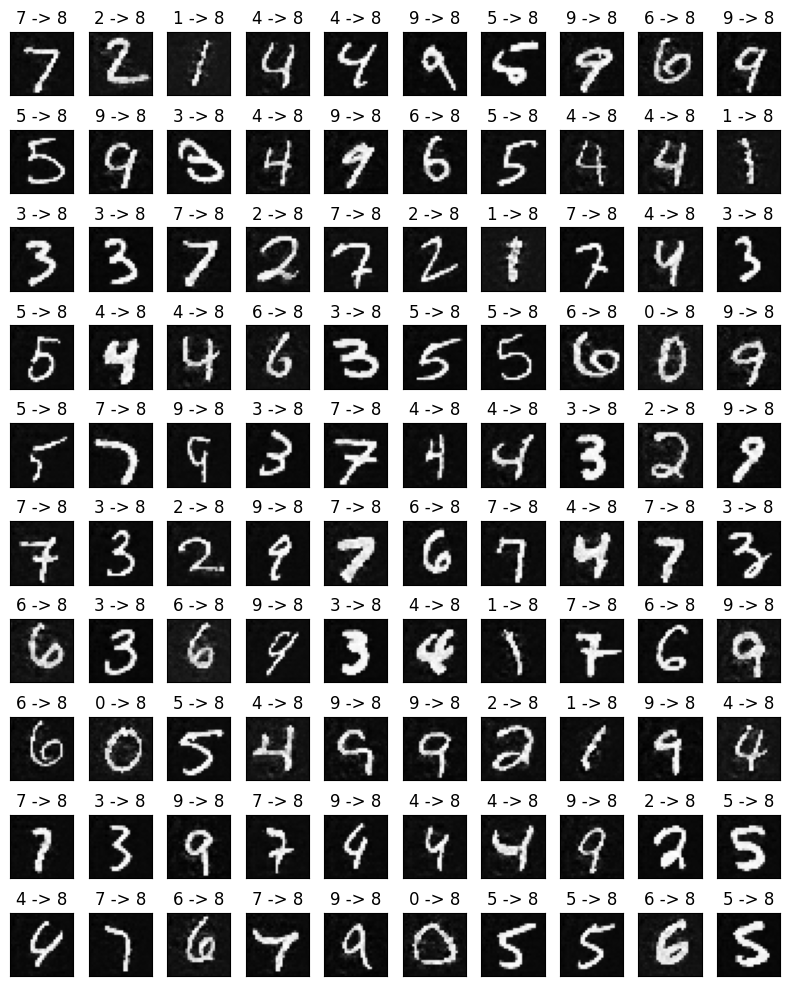

In [9]:
num_cols = len(adv_examples)
print(num_cols)


plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### Untargeted attack

In [10]:
adv_examples = test_cw(mnist_resnet_model, test_loader_mnist, mnist = 1)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
0 / 11
0 / 12
0 / 13
0 / 14
1 / 15
1 / 16
1 / 17
1 / 18
1 / 19
1 / 20
1 / 21
1 / 22
1 / 23
1 / 24
1 / 25
1 / 26
1 / 27
1 / 28
1 / 29
1 / 30
1 / 31
2 / 32
2 / 33
2 / 34
2 / 35
2 / 36
2 / 37
3 / 38
3 / 39
3 / 40
4 / 41
4 / 42
4 / 43
4 / 44
4 / 45
4 / 46
5 / 47
5 / 48
5 / 49
5 / 50
5 / 51
5 / 52
5 / 53
5 / 54
5 / 55
5 / 56
5 / 57
5 / 58
5 / 59
5 / 60
5 / 61
5 / 62
5 / 63
5 / 64
5 / 65
5 / 66
5 / 67
5 / 68
5 / 69
5 / 70
5 / 71
5 / 72
5 / 73
5 / 74
6 / 75
6 / 76
6 / 77
6 / 78
6 / 79
6 / 80
6 / 81
6 / 82
6 / 83
6 / 84
6 / 85
6 / 86
6 / 87
6 / 88
6 / 89
6 / 90
6 / 91
6 / 92
6 / 93
6 / 94
7 / 95
7 / 96
7 / 97
7 / 98
7 / 99
7 / 100
7 / 101
7 / 102
7 / 103
7 / 104
7 / 105
7 / 106
7 / 107
7 / 108
Accuracy of test text: 6.481481 %


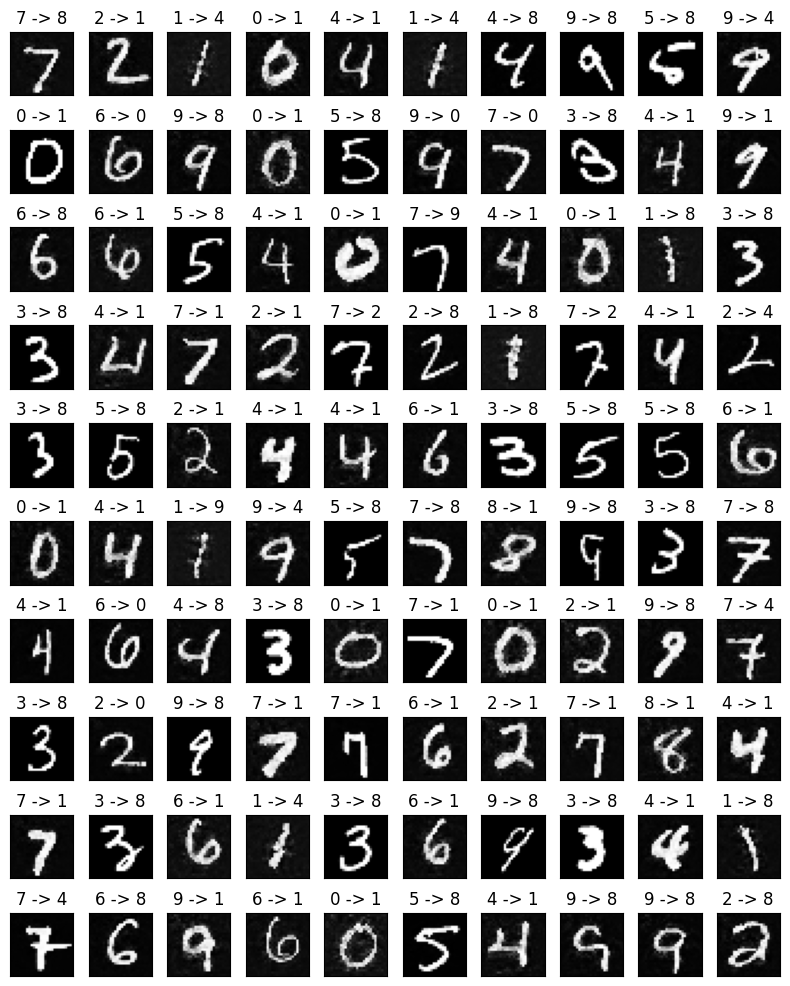

In [11]:
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## CIFAR10 Dataset

### Targeted attack

In [12]:
adv_examples = test_cw(cifar_resnet_model, test_loader_cifar10, targeted =True, target_label = 3, mnist = 0)

1 / 1
1 / 2
1 / 3
1 / 4
1 / 5
1 / 6
1 / 7
1 / 8
2 / 9
2 / 10
2 / 11
2 / 12
2 / 13
2 / 14
2 / 15
2 / 16
2 / 17
2 / 18
2 / 19
2 / 20
2 / 21
2 / 22
2 / 23
2 / 24
2 / 25
2 / 26
2 / 27
2 / 28
2 / 29
2 / 30
2 / 31
2 / 32
2 / 33
2 / 34
2 / 35
2 / 36
2 / 37
2 / 38
2 / 39
2 / 40
2 / 41
2 / 42
2 / 43
2 / 44
2 / 45
2 / 46
3 / 47
3 / 48
3 / 49
3 / 50
3 / 51
3 / 52
3 / 53
4 / 54
4 / 55
4 / 56
4 / 57
4 / 58
4 / 59
4 / 60
4 / 61
5 / 62
5 / 63
6 / 64
6 / 65
6 / 66
6 / 67
6 / 68
7 / 69
7 / 70
7 / 71
7 / 72
7 / 73
7 / 74
7 / 75
7 / 76
7 / 77
8 / 78
9 / 79
9 / 80
9 / 81
9 / 82
9 / 83
9 / 84
9 / 85
9 / 86
9 / 87
9 / 88
9 / 89
9 / 90
9 / 91
10 / 92
10 / 93
10 / 94
10 / 95
10 / 96
10 / 97
10 / 98
10 / 99
10 / 100
10 / 101
10 / 102
10 / 103
11 / 104
11 / 105
11 / 106
12 / 107
12 / 108
12 / 109
12 / 110
12 / 111
12 / 112
12 / 113
Accuracy of test text: 10.619469 %


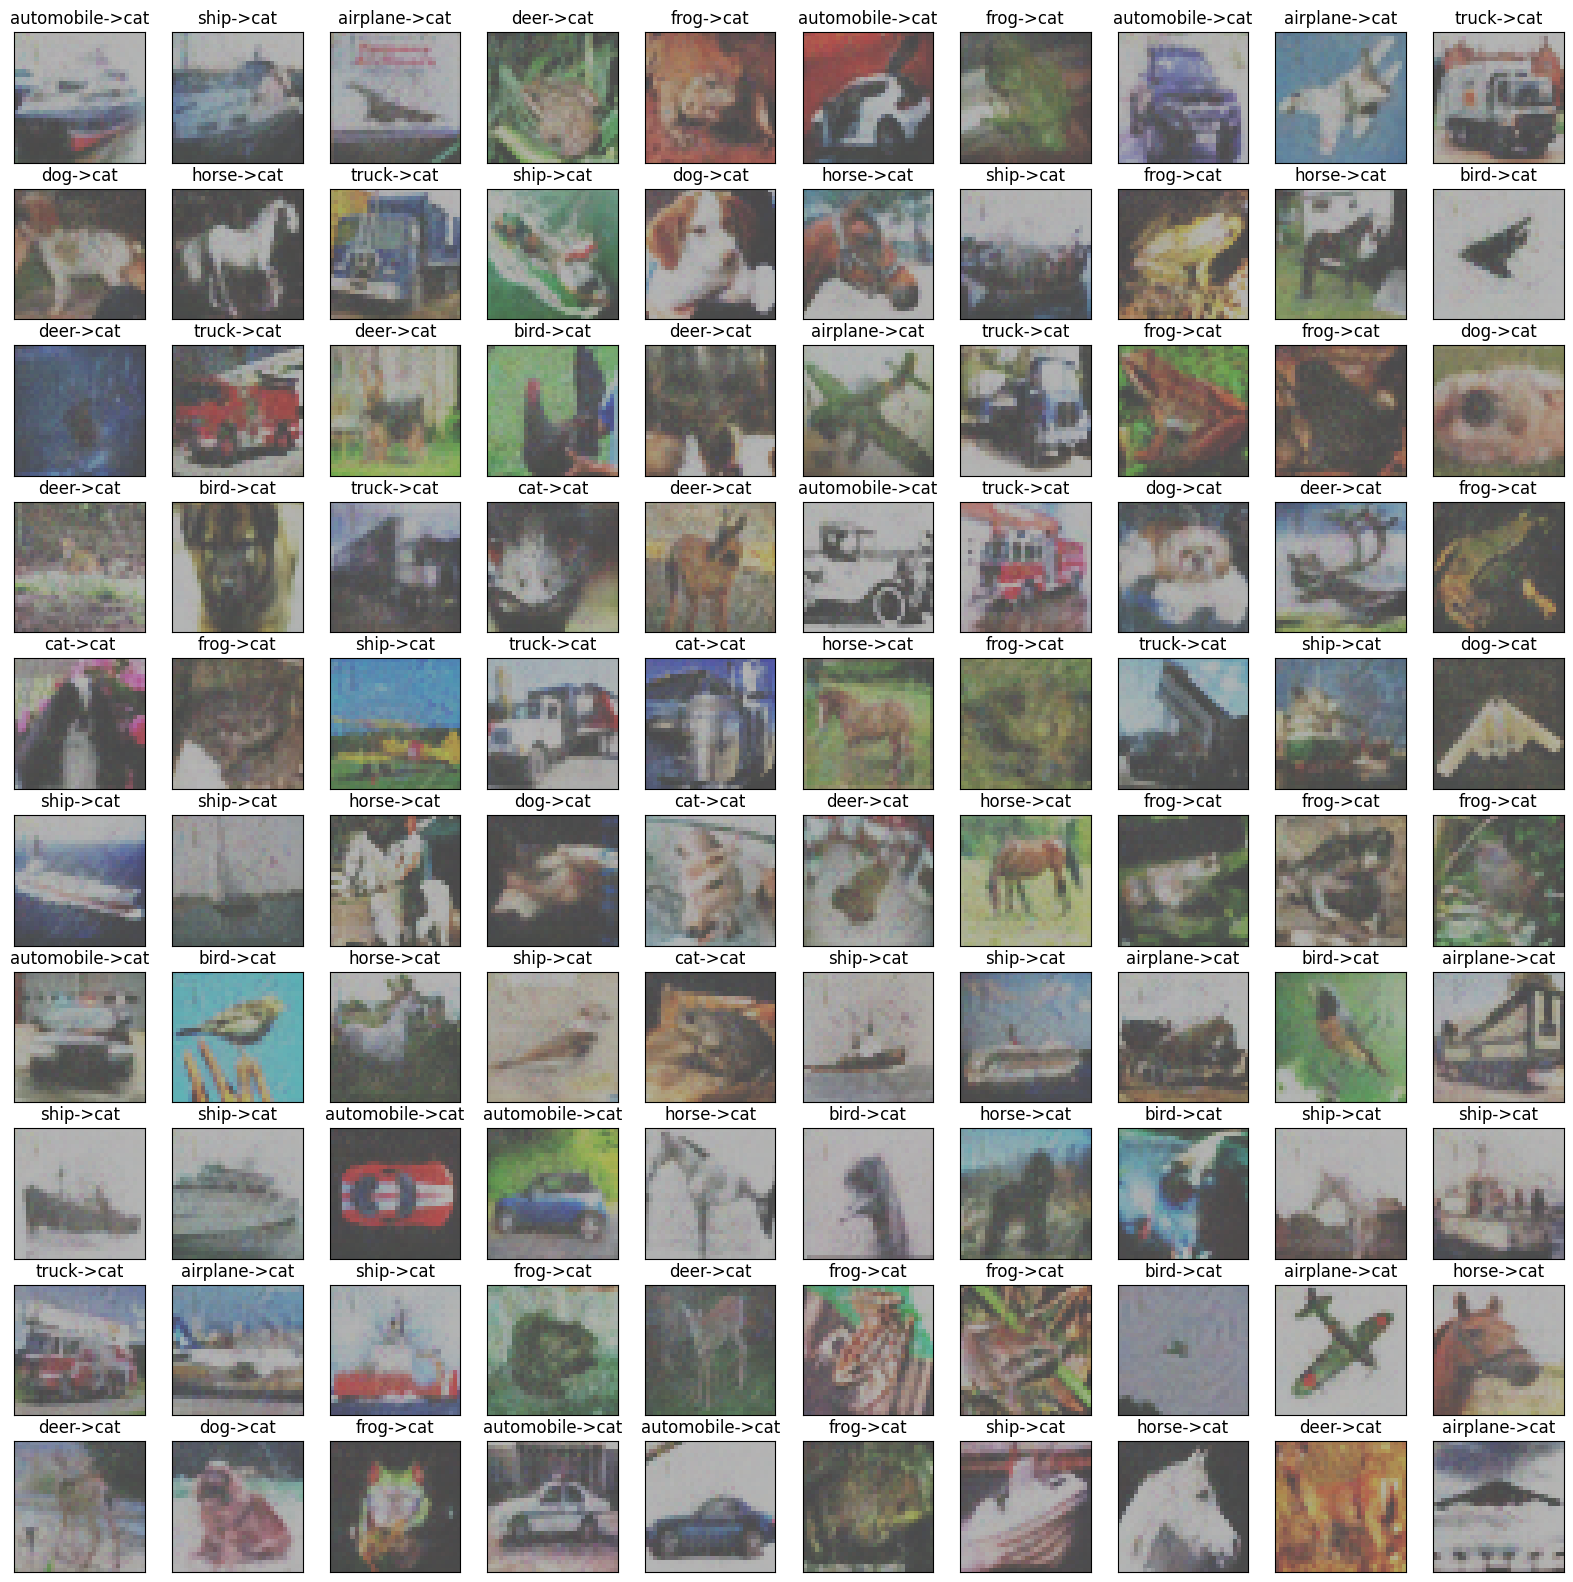

In [13]:
# CIFAR-10
label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

plt.figure(figsize=(20, 20))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex  # Normalizing pixel values
    plt.title(f"{label_mapping[orig]}->{label_mapping[adv]}")
    plt.imshow(ex)

plt.show()


### Untargeted attack

In [14]:
adv_examples = test_cw(cifar_resnet_model, test_loader_cifar10, mnist = 0)

0 / 1
1 / 2
1 / 3
1 / 4
1 / 5
1 / 6
1 / 7
1 / 8
1 / 9
1 / 10
1 / 11
1 / 12
1 / 13
1 / 14
1 / 15
1 / 16
1 / 17
1 / 18
1 / 19
1 / 20
1 / 21
2 / 22
2 / 23
2 / 24
2 / 25
2 / 26
2 / 27
2 / 28
2 / 29
2 / 30
2 / 31
2 / 32
2 / 33
2 / 34
2 / 35
2 / 36
2 / 37
2 / 38
2 / 39
2 / 40
2 / 41
2 / 42
2 / 43
2 / 44
2 / 45
2 / 46
2 / 47
2 / 48
2 / 49
2 / 50
2 / 51
2 / 52
2 / 53
2 / 54
2 / 55
2 / 56
2 / 57
2 / 58
2 / 59
2 / 60
2 / 61
3 / 62
3 / 63
3 / 64
3 / 65
4 / 66
4 / 67
4 / 68
4 / 69
4 / 70
4 / 71
4 / 72
4 / 73
4 / 74
4 / 75
4 / 76
4 / 77
4 / 78
4 / 79
4 / 80
4 / 81
4 / 82
4 / 83
4 / 84
4 / 85
4 / 86
4 / 87
4 / 88
4 / 89
4 / 90
4 / 91
5 / 92
5 / 93
5 / 94
5 / 95
5 / 96
5 / 97
5 / 98
5 / 99
5 / 100
5 / 101
5 / 102
5 / 103
5 / 104
5 / 105
5 / 106
Accuracy of test text: 4.716981 %


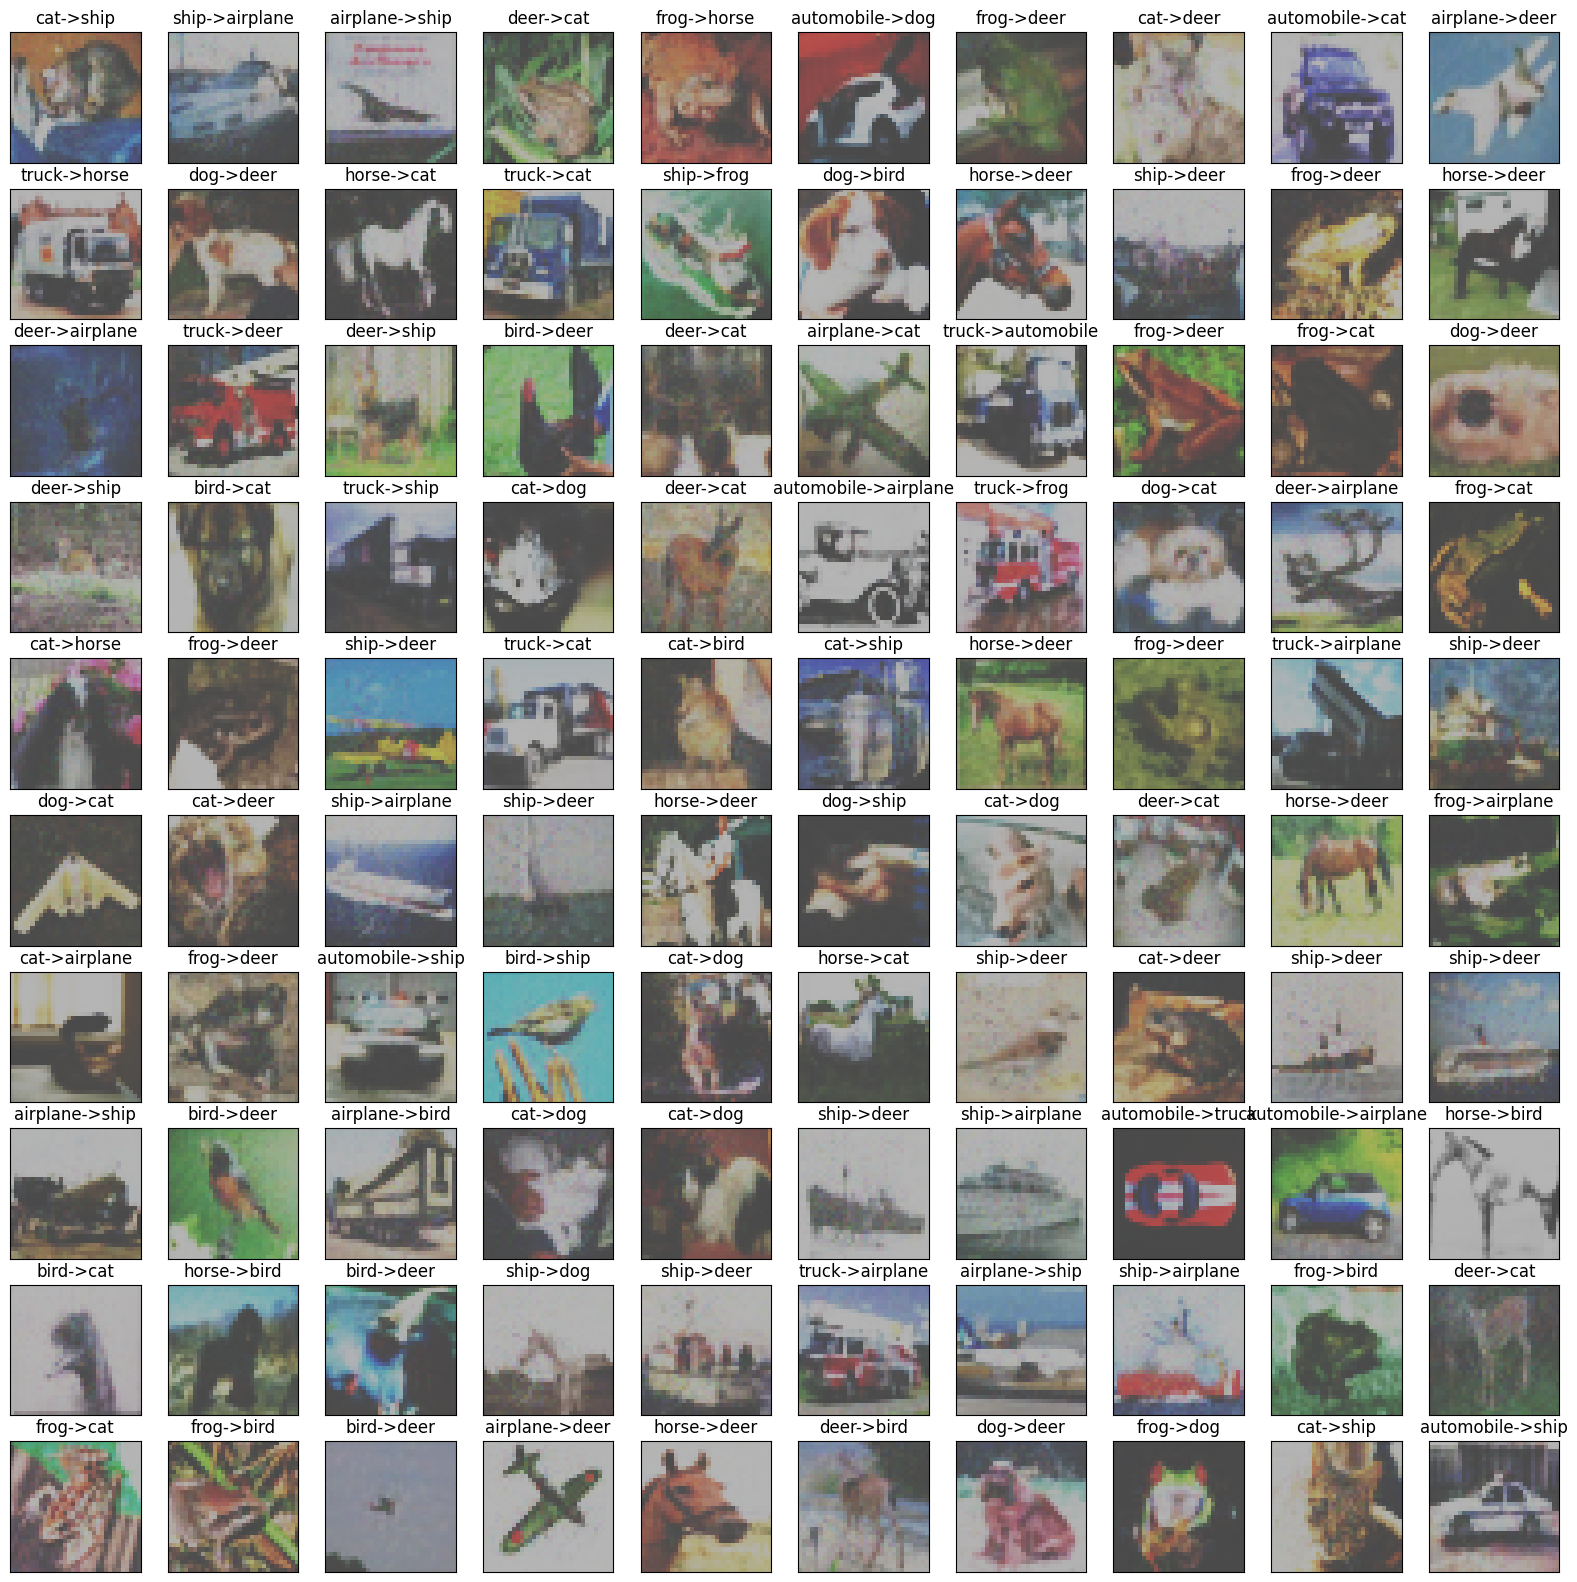

In [15]:
# CIFAR-10
label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

plt.figure(figsize=(20, 20))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex  # Normalizing pixel values
    plt.title(f"{label_mapping[orig.item()]}->{label_mapping[adv.item()]}")
    plt.imshow(ex)

plt.show()


## SVHN Dataset

### Targeted attack

In [16]:
adv_examples = test_cw(svhn_resnet_model, test_loader_svhn, targeted =True, target_label = 4, mnist = 0)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
0 / 11
0 / 12
0 / 13
0 / 14
1 / 15
2 / 16
2 / 17
2 / 18
2 / 19
3 / 20
3 / 21
3 / 22
3 / 23
3 / 24
3 / 25
3 / 26
4 / 27
4 / 28
5 / 29
5 / 30
5 / 31
5 / 32
5 / 33
5 / 34
5 / 35
5 / 36
5 / 37
5 / 38
5 / 39
5 / 40
5 / 41
5 / 42
5 / 43
5 / 44
5 / 45
5 / 46
5 / 47
5 / 48
5 / 49
5 / 50
5 / 51
5 / 52
5 / 53
5 / 54
5 / 55
5 / 56
5 / 57
5 / 58
5 / 59
5 / 60
5 / 61
5 / 62
5 / 63
6 / 64
6 / 65
6 / 66
6 / 67
6 / 68
6 / 69
6 / 70
6 / 71
6 / 72
6 / 73
6 / 74
7 / 75
7 / 76
7 / 77
7 / 78
7 / 79
7 / 80
8 / 81
8 / 82
8 / 83
8 / 84
8 / 85
8 / 86
8 / 87
8 / 88
8 / 89
8 / 90
9 / 91
10 / 92
10 / 93
11 / 94
12 / 95
12 / 96
12 / 97
12 / 98
12 / 99
12 / 100
13 / 101
13 / 102
13 / 103
13 / 104
13 / 105
13 / 106
13 / 107
13 / 108
13 / 109
13 / 110
13 / 111
13 / 112
13 / 113
13 / 114
Accuracy of test text: 11.403509 %


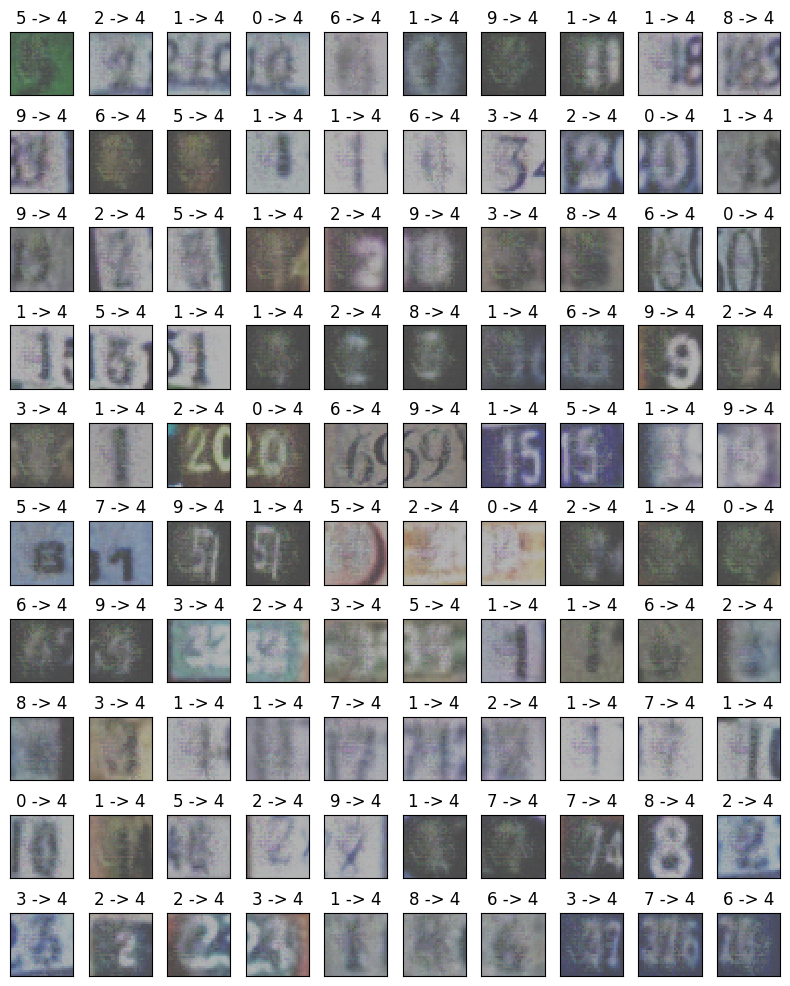

In [17]:
# Test visualizer with an image available in test data
viz = Visualizer()

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex # /255 # Normalizing pixel values
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex)
plt.tight_layout()
plt.show()

## Untargeted attack

In [18]:
adv_examples = test_cw(svhn_resnet_model, test_loader_svhn, mnist = 0)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
1 / 11
1 / 12
1 / 13
1 / 14
1 / 15
1 / 16
1 / 17
1 / 18
1 / 19
1 / 20
1 / 21
1 / 22
1 / 23
2 / 24
2 / 25
2 / 26
2 / 27
2 / 28
2 / 29
2 / 30
2 / 31
2 / 32
2 / 33
2 / 34
2 / 35
2 / 36
2 / 37
2 / 38
2 / 39
2 / 40
2 / 41
2 / 42
2 / 43
2 / 44
2 / 45
2 / 46
2 / 47
2 / 48
2 / 49
2 / 50
2 / 51
2 / 52
2 / 53
2 / 54
2 / 55
3 / 56
3 / 57
4 / 58
4 / 59
4 / 60
4 / 61
4 / 62
4 / 63
4 / 64
4 / 65
4 / 66
4 / 67
4 / 68
4 / 69
4 / 70
4 / 71
4 / 72
4 / 73
4 / 74
4 / 75
4 / 76
4 / 77
4 / 78
4 / 79
4 / 80
4 / 81
4 / 82
4 / 83
4 / 84
4 / 85
4 / 86
4 / 87
4 / 88
4 / 89
4 / 90
4 / 91
4 / 92
5 / 93
5 / 94
5 / 95
5 / 96
5 / 97
5 / 98
5 / 99
5 / 100
5 / 101
5 / 102
5 / 103
5 / 104
5 / 105
5 / 106
Accuracy of test text: 4.716981 %
